In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
def histogram_residuals(mu_ss, mu_gp, var_ss, var_gp):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), sharey=True)
    ax1.hist(mu_ss-mu_gp)
    ax2.hist(var_ss-var_gp)
    ax1.set(xlabel='$\mu_{ss} - \mu_{gp}$', )
    ax2.set(xlabel='$\sigma^2_{ss} - \sigma^2_{gp}$');
    fig.tight_layout()
    return fig, (ax1, ax2)

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

## Import `onefit` to get full GP version of SHO 

In [6]:
import sys
sys.path.insert(0, '/Users/rrubenzahl/Research/Solar/onefit/onefit/')

In [7]:
import importlib
import gpkernels
importlib.reload(gpkernels)
from gpkernels import *

# SHO Kernel in `tinygp` and `smolgp`

In [8]:
import tinygp
import smolgp

In [9]:
S=2.36
w=0.0195
Q=7.63
sigma = jnp.sqrt(S*w*Q)

qsSHO = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
ssSHO =smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
gpSHO = gpkernels.OscillationKernel()

Defaulting to solar values.


In [10]:
%%timeit -n 100
qsSHO = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)

19 μs ± 1.12 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit -n 100
ssSHO =smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)

21.9 μs ± 1.69 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Use tinygp to define a 'ground truth' process

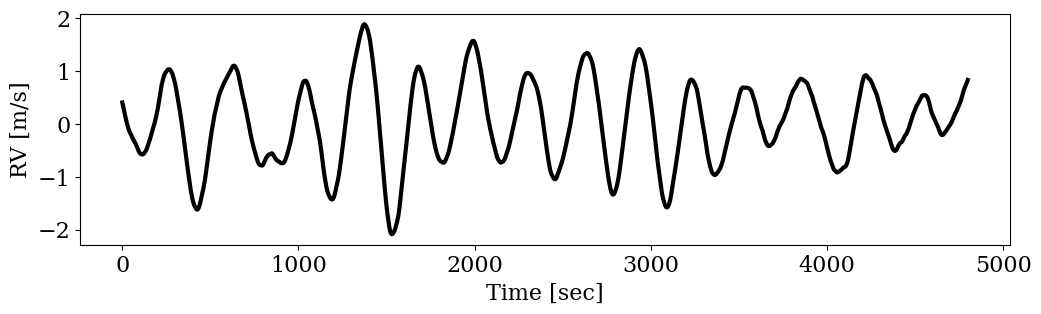

In [12]:
def get_true_gp(tmax, tunit='s', dt=1):
    t = u.Quantity(jnp.arange(0, tmax, dt), tunit).to('s').value
    true_gp = tinygp.GaussianProcess(qsSHO, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=10/60)
    return t, f

baseline_minutes = 80
t, f = get_true_gp(baseline_minutes, 'min', dt=1/60)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(t, f(t), label='Example SHO', color='k', lw=3)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

## Make synthetic observations

In [13]:
#### Simulated dataset
def generate_data(N, yerr=0.3, tmin=None, tmax=None, baseline_minutes=80):

    # Generate true GP over baseline
    t, f = get_true_gp(baseline_minutes, 'min', dt=1/60)
    tmin = t.min() if tmin is None else tmin
    tmax = t.max() if tmax is None else tmax

    # Generate synthetic observations (no exposure time)
    t_train = jnp.linspace(tmin, tmax, N)
    y_true = f(t_train)
    y_train = y_true + yerr * jax.random.normal(key, shape=(N,))
    return t_train, y_train

In [14]:
np.random.seed(231)

N = 30
yerr = 0.3 # m/s
t_train, y_train = generate_data(N, yerr)

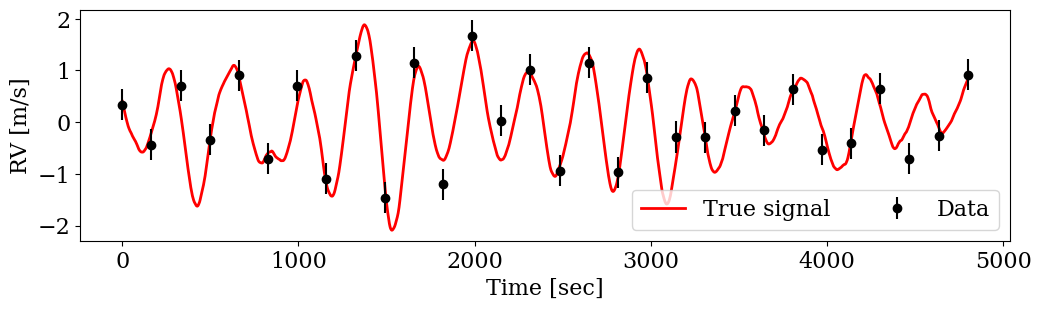

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data')

ax.legend(ncol=2)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [16]:
def sample_data(N, yerr=0.3):
    return generate_data(N, qsSHO, yerr=yerr)

# Benchmarking

In [17]:
import importlib

import benchmark
importlib.reload(benchmark)
from benchmark import *

## Likelihood

In [18]:
## Individual call signatures
gp_ss =smolgp.GaussianProcess(ssSHO, t_train, diag=yerr**2)
gp_qs = tinygp.GaussianProcess(qsSHO, t_train, diag=yerr**2)
gp_gp = tinygp.GaussianProcess(gpSHO, t_train, diag=yerr**2)

In [19]:
(Ns, outputs), (runtime_ss_llh, runtime_qs_llh, runtime_gp_llh) \
        = benchmark_llh(ssSHO, qsSHO, gpSHO=gpSHO,
                        true_kernel=qsSHO, yerr=yerr,
                        N_N=10, n_repeat=1, 
                        logN_min=1, logN_max=7)

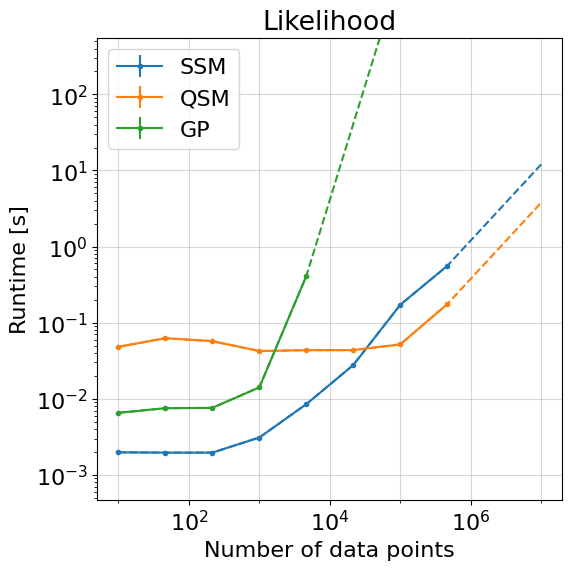

In [20]:
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True)

savefig = '/Users/rrubenzahl/Desktop/figures/benchmark_llh.png'
ax = plot_benchmark(Ns, runtime_ss_llh, runtime_qs_llh, runtime_gp_llh, 
                    ax=ax, labels=['SSM', 'QSM', 'GP'],)# savefig=savefig)
ax.legend(loc='upper left')
ax.set_title('Likelihood')
plt.savefig(savefig, dpi=300, bbox_inches='tight')

### Verification of outputs


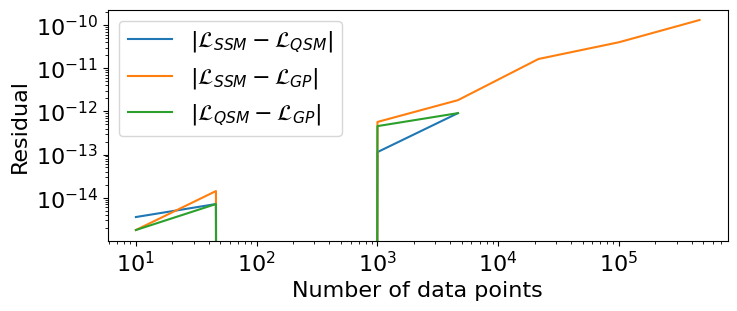

In [21]:
res_qs_ss = jnp.abs(outputs[:,0] - outputs[:,1])
res_qs_gp = jnp.abs(outputs[:,2] - outputs[:,1])
res_ss_gp = jnp.abs(outputs[:,0] - outputs[:,2])

fig, ax = plt.subplots(1,1, figsize=(8,3), sharex=True)
ax.plot(Ns, res_qs_gp, label='$|\mathcal{L}_{SSM} - \mathcal{L}_{QSM}$|')
ax.plot(Ns, res_qs_ss, label='$|\mathcal{L}_{SSM} - \mathcal{L}_{GP}$|')
ax.plot(Ns, res_ss_gp, label='$|\mathcal{L}_{QSM} - \mathcal{L}_{GP}$|')
ax.set(yscale='log', xscale='log', xlabel='Number of data points', ylabel='Residual');
ax.legend();

## Conditioning at the data points

In [22]:
N = 1000
t_train, y_train = sample_data(N)

## Build GP for given dataset
gp_ss =smolgp.GaussianProcess(ssSHO, t_train, diag=yerr**2)
gp_qs = tinygp.GaussianProcess(qsSHO, t_train, diag=yerr**2)
gp_gp = tinygp.GaussianProcess(gpSHO, t_train, diag=yerr**2)

### method 1/default: `GaussianProcess.condition`

In [23]:
## Condition on data, returns likelihood and 
## conditioned GP object w/ predictions at data points
llh, condGP = gp_ss.condition(y_train)

In [24]:
%%timeit -n 10
## Method 1: use gp.condition which also returns the likelihood
llh, condGP = gp_ss.condition(y_train)
## Then the mean and variance can be extracted from the conditioned GP attributes
mu  = condGP.loc #- y_ss
var = condGP.var #- yvar_ss

llh, mu, var

11.4 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### method 2: `GaussianProcess.predict` with a data array

In [25]:
## we can also use predict from an unconditioned GP 
## and it will condition it using self.condition
## in which case we need to give predict a time and data array `y`
## but can pass None to X_test to have it use the data coordinates
mu, var = gp_ss.predict(None, y_train, return_var=True)

In [26]:
%%timeit -n 10
gp_ss.predict(None, y_train)

9.66 ms ± 912 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### benchmark

In [27]:
import benchmark
importlib.reload(benchmark)
from benchmark import *

In [28]:
(Ns, outputs), (runtime_ss_cond, runtime_qs_cond, runtime_gp_cond) \
        = benchmark_condition(ssSHO, qsSHO, gpSHO=gpSHO,
                        true_kernel=qsSHO, yerr=yerr,
                        N_N=10, n_repeat=3, 
                        logN_min=1, logN_max=7,
                        ss_cutoff=1e6, qs_cutoff=1e5, gp_cutoff=1e4)

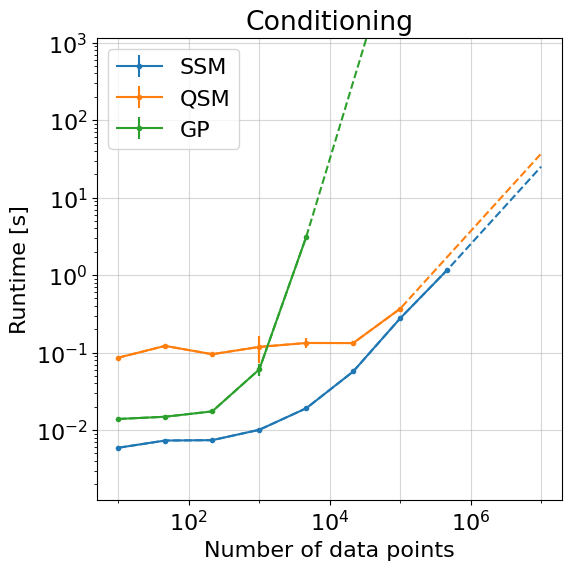

In [29]:
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True)

savefig = '/Users/rrubenzahl/Desktop/figures/benchmark_condition.png'
ax = plot_benchmark(Ns, runtime_ss_cond, runtime_qs_cond, runtime_gp_cond, 
                    ax=ax, labels=['SSM', 'QSM', 'GP'],)# savefig=savefig)
ax.legend(loc='upper left')
ax.set_title('Conditioning')
plt.savefig(savefig, dpi=300, bbox_inches='tight')


### Verification of outputs

## Predicting at test points

In [30]:
## Can use condGP to then make predictions
## useful for speed if making multiple different 
## predictions based on a single conditioned GP
##
## by default just returns the already computed 
# conditioned mean/ar at the data points
mu, var = condGP.predict(return_var=True)

In [31]:
M = 10000
t_test = jnp.linspace(t.min(), t.max(), M)

In [35]:
%%timeit -n 10
mu, var = condGP.predict(t_test, return_var=True)
mu.block_until_ready(), var.block_until_ready();

3.85 ms ± 315 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%%timeit -n 10
mu, var = gp_qs.predict(y_train, t_test, return_var=True)
mu.block_until_ready(); var.block_until_ready();

176 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
_, condGPqs = gp_qs.condition(y_train)

### benchmark

In [37]:
import benchmark
importlib.reload(benchmark)
from benchmark import *

In [38]:
(Ns, outputs), (runtime_ss_pred, runtime_qs_pred, runtime_gp_pred) \
        = benchmark_prediction(ssSHO, qsSHO, gpSHO=gpSHO,
                        true_kernel=qsSHO, yerr=yerr,
                        N_M=10, n_repeat=3, 
                        logM_min=1, logM_max=7,
                        ss_cutoff=1e6, qs_cutoff=1e5, gp_cutoff=1e5)

NOTE: WERE ONLY TIMING PREDICTIONS, NOT INIT+CONDITION


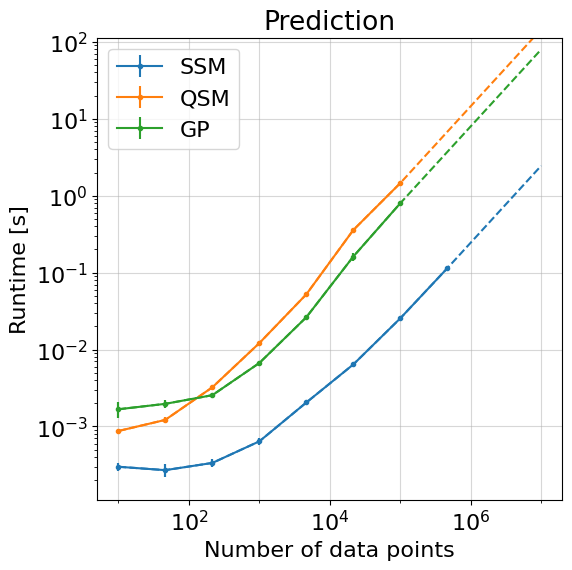

In [39]:
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True)

savefig = '/Users/rrubenzahl/Desktop/figures/benchmark_predict.png'
ax = plot_benchmark(Ns, runtime_ss_pred, runtime_qs_pred, runtime_gp_pred, 
                    ax=ax, labels=['SSM', 'QSM', 'GP'],
                    powers=[1,1,1])# savefig=savefig)
ax.legend(loc='upper left')
ax.set_title('Prediction')
plt.savefig(savefig, dpi=300, bbox_inches='tight')

print('NOTE: WERE ONLY TIMING PREDICTIONS, NOT INIT+CONDITION')

In [40]:
# fig, (ax1, ax2) = histogram_residuals(mu_ss, mu_gp, var_ss, var_gp)

### Verification of outputs

# Full benchmarking plot

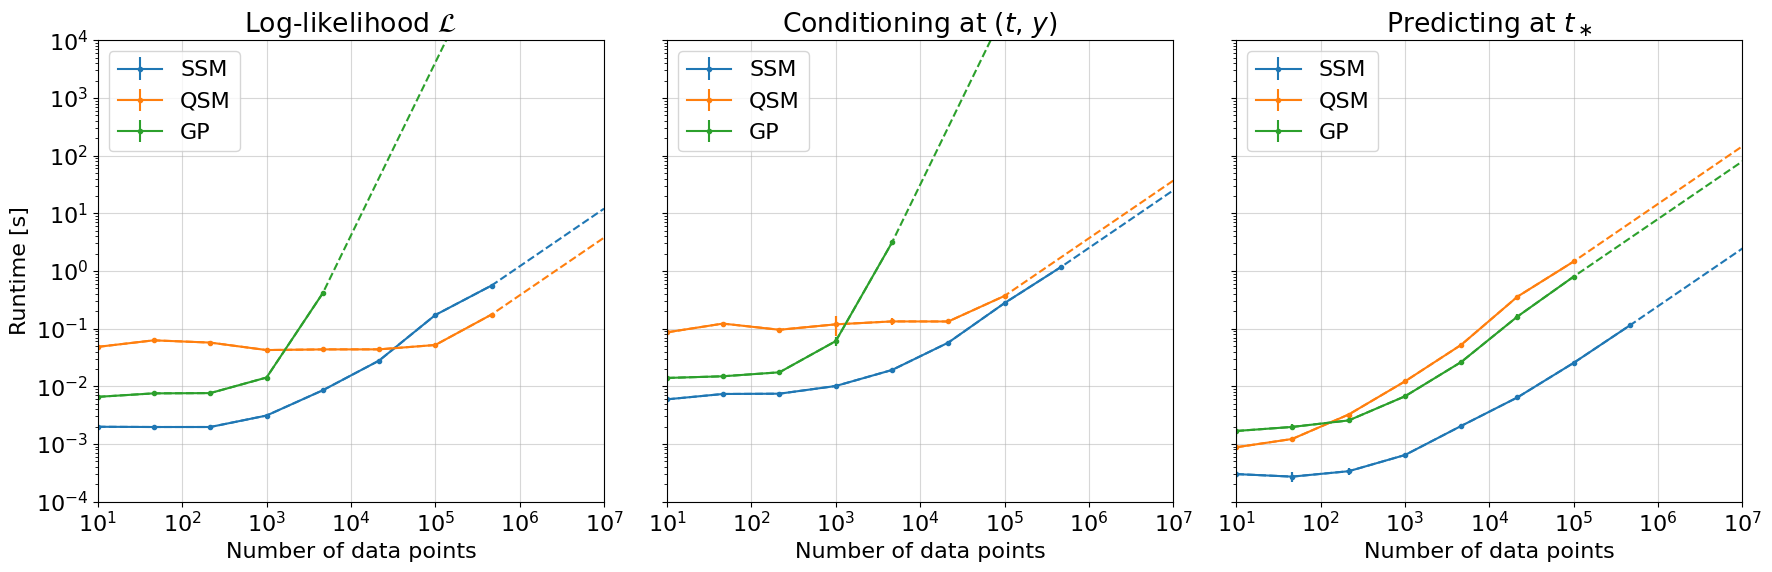

In [41]:
savefig = '/Users/rrubenzahl/Desktop/figures/benchmark_cpu.png'

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6), sharex=True, sharey=True)

ax1 = plot_benchmark(Ns, runtime_ss_llh, runtime_qs_llh, runtime_gp_llh, 
                    ax=ax1, labels=['SSM', 'QSM', 'GP'],)# savefig=savefig)
ax1.legend(loc='upper left')
ax1.set_title('Log-likelihood $\mathcal{L}$')

ax2 = plot_benchmark(Ns, runtime_ss_cond, runtime_qs_cond, runtime_gp_cond, 
                    ax=ax2, labels=['SSM', 'QSM', 'GP'],)# savefig=savefig)
ax2.legend(loc='upper left')
ax2.set(title=r'Conditioning at ($t$, $y$)', ylabel=None)

ax3 = plot_benchmark(Ns, runtime_ss_pred, runtime_qs_pred, runtime_gp_pred, 
                    ax=ax3, labels=['SSM', 'QSM', 'GP'], powers=[1,1,1])# savefig=savefig)
ax3.legend(loc='upper left')
ax3.set(title=r'Predicting at $t_\ast$', ylabel=None)
ax1.set(xlim=[Ns.min(), Ns.max()], ylim=[1e-4, 1e4])
fig.tight_layout()
plt.savefig(savefig, dpi=300, bbox_inches='tight')

## Test multicomponent models

In [ ]:
kernel1 = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
kernel2 = smolgp.kernels.SHO(omega=0.00234587265, 
                              quality=1/jnp.sqrt(2), 
                              sigma=0.329)
kernel = kernel1 + kernel2

TypeError: Can't instantiate abstract class Sum with abstract method noise

### Full GP prediction

In [ ]:
diag = yerr**2 

shokern = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
gp = tinygp.GaussianProcess(shokern, t_train, diag=diag)
y_gp, yvar_gp = gp.predict(y_train, t_train, kernel=shokern, return_var=True)
mu_gp, var_gp = gp.predict(y_train, t_test,  kernel=shokern, return_var=True)
yerr_gp = jnp.sqrt(yvar_gp)
std_gp  = jnp.sqrt(var_gp)

### Plot

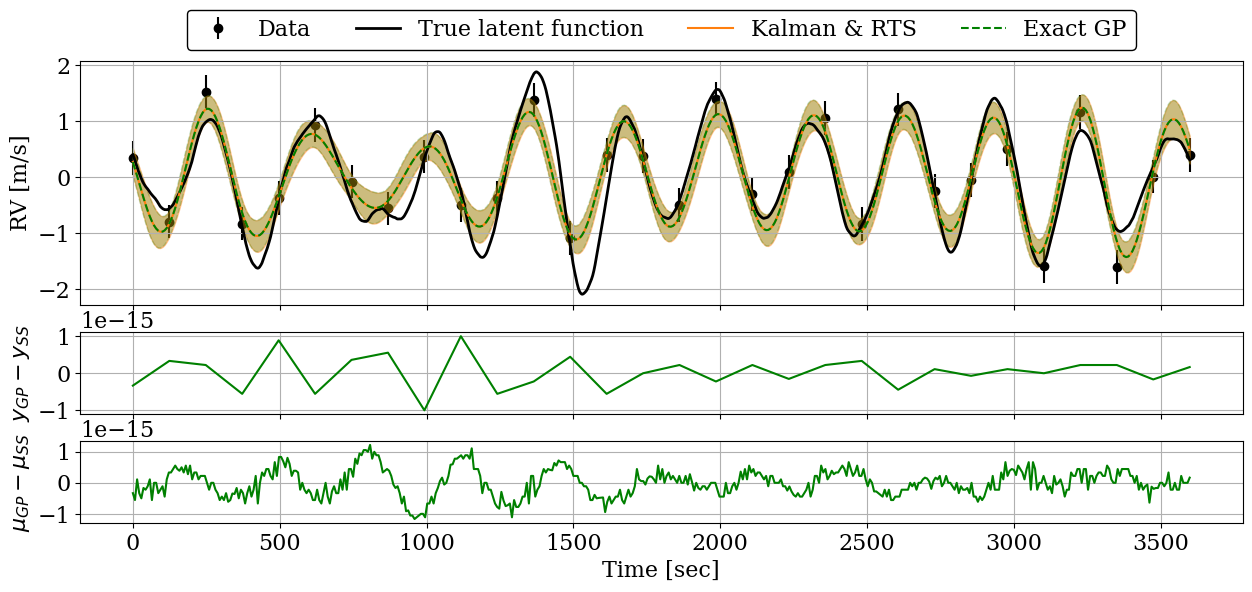

In [ ]:
fig, (ax, rax1, rax2) = plt.subplots(3,1, figsize=(15, 6), sharex=True, gridspec_kw={'height_ratios':[3,1,1]})

cobs = 'k' # 'w'
ctrue = 'k'
cgp  = 'g'
ckal = 'C0'
crts = 'C1'

## Data and true signal
l1 = ax.errorbar(t_train, y_train, yerr, fmt='o', zorder=0, color=cobs, label="Data")
l2, = ax.plot(t, f(t), color=ctrue, lw=2, label="True latent function")

## Kalman filtered result
# l3, = ax.plot(t_train, y_kal, 'o', color=ckal,  ls=':',  label="Kalman Filtered Mean")
# ax.fill_between(t_train, y_kal-yerr_kal, y_kal+yerr_kal, color=ckal, alpha=0.2)

# ## RTS smoothed result
# l4, = ax.plot(t_train, y_ss, 'o', color=crts,  ls='-', label="RTS Smoothed Mean")
# ax.fill_between(t_train, y_ss-yerr_ss, y_ss+yerr_ss, color=crts, alpha=0.2)

# ## GP solution
# l5, = ax.plot(t_train, y_gp, 'o', color=cgp,   ls='-',  label="Exact GP Mean")
# ax.fill_between(t_train, y_gp-yerr_gp, y_gp+yerr_gp, color=cgp, alpha=0.2)

## Test predictions
l4, = ax.plot(t_test, mu_ss, color=crts,  ls='-', label="Kalman & RTS")
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, ls='-', color=crts, alpha=0.4)

l5, = ax.plot(t_test, mu_gp,  color=cgp,   ls='--',  label="Exact GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, ls='--', color=cgp, alpha=0.2)

lines = [l1, l2, l4, l5]
ax.legend(lines, [l.get_label() for l in lines],
            ncol=4,# loc='upper center', #fontsize=14,
            loc='lower center', bbox_to_anchor=[0.5,1],
              framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
# ax.set_title("State-Space GP vs. Exact GP")
ax.set(ylabel='RV [m/s]', )#xlim=[max(t_test.min(), t.min().to(kernel.tunit).value),
                        #  min(t_test.max(), t.max().to(kernel.tunit).value)])
# ax.set_ylim(f(t).min()-.2, f(t).max()+1)
ax.grid()

# rax.plot(t_train, y_kal-y_true, ckal, ls=':')
rax1.plot(t_train, y_gp-y_ss,  cgp , ls='-')
# rax1.plot(t_train, )

mu_true = f(t_test/60)
rax2.plot(t_test, mu_gp-mu_ss, c=cgp , ls='-')
# rax2.fill_between(t_test, (mu_ss-std_ss) - (mu_gp-std_gp), 
#                           (mu_ss+std_ss) - (mu_gp+std_gp), 
#                   ls='--', color='k', alpha=0.2)

rax1.set(ylabel=r'$y_{GP}-y_{SS}$')
rax2.set(xlabel='Time [sec]', ylabel=r'$\mu_{GP}-\mu_{SS}$')

rax1.grid();rax2.grid();

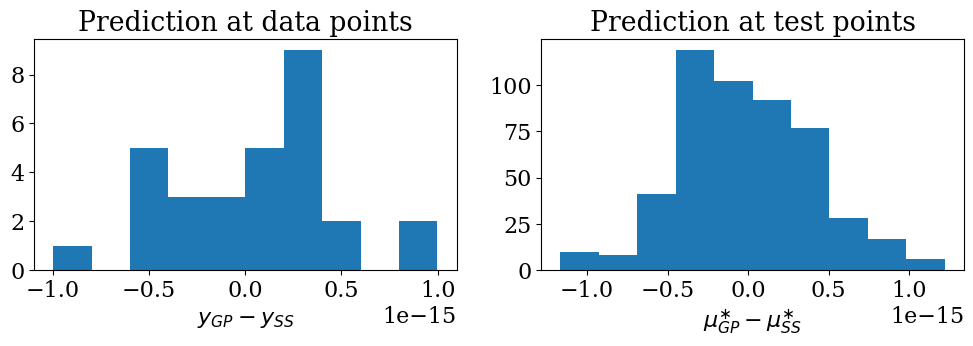

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_gp - y_ss);
# ax1.hist(yvar_gp - yvar_ss);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$')

ax2.hist(mu_gp - mu_ss);
# ax2.hist(var_gp - var_ss);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');

# Integrated version: to be moved into `smolgp`

and then make a copy of this testing notebook to `testing.ipynb` and run benchmarking

## Augmented matrices

In [ ]:
d = F.shape[0] # dimensionality of the SDE
I = jnp.eye(d)
Z = jnp.zeros((d,d))

#### Augmented matrices to define: F, L, and optionally A (can always use A(dt) = expm(F*dt))
#### Generalized augmented matrix construction
#### given number of instruments
Ninst = 2
#################
L_aug = jnp.vstack([L] + [jnp.zeros_like(L)]*Ninst)
F_aug = [[F] + [Z]*Ninst]
for inst in range(Ninst):
    F_aug.append([I] + [Z]*Ninst)
F_aug = jnp.block(F_aug)

# A_aug = lambda dt: expm(F_aug*dt)
def A_aug(dt):
    ''' Augmented transition matrix for multi-instrument model '''
    PHI    = Phi(dt)
    INTPHI = Phibar(dt)
    top = [PHI] + [Z]*Ninst
    mids = []
    for inst in range(Ninst):
        row = [INTPHI] + [Z]*Ninst
        row[1+inst] = I
        mids.append(row)
    return jnp.block([top] + mids)

def Reset_matrix(instid):
    ''' Reset matrix for instrument `instid` (0-indexed) '''
    diag = jnp.ones(d*(Ninst+1))
    diag = jax.lax.dynamic_update_slice(diag, jnp.zeros(d), (d*(1+instid),))
    return jnp.diag(diag)

## Define Q using Van-Loan expm
Q_aug = lambda dt: Q_from_VanLoan(F_aug, L_aug, Qc, dt)

In [ ]:
L_aug.shape, F_aug.shape, A_aug(3).shape, Q_aug(3).shape, Reset_matrix(0).shape

((6, 1), (6, 6), (6, 6), (6, 6), (6, 6))

>Note: $\bm{\bar{\Phi}}$ can be computed through an analagous matrix exponential as $\bm{Q}$ ([Van Loan 1978](https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c)) 

In [ ]:
def Phibar_from_VanLoan(F, dt):
    '''
    Van Loan method to compute Phibar = ∫0^dt exp(F s) ds

    See Van Loan (1978) "Computing Integrals Involving the Matrix Exponential"
    PDF at https://www.olemartin.no/artikler/vanloan.pdf
    https://ecommons.cornell.edu/items/cba38b2e-6ad4-45e6-8109-0a019fe5114c
    '''
    b = len(F) # block size
    Z = jnp.zeros((b,b))
    I = jnp.eye(b)
    C = jnp.block([[F, I],[Z, Z]])
    VanLoanBlock = expm(C*dt)
    G3 = VanLoanBlock[:b,b:]
    return G3

In [ ]:
jnp.all(jax.vmap(lambda dt: jnp.allclose(Phibar(dt), Phibar_from_VanLoan(F, dt)))(dts))

Array(True, dtype=bool)

In [ ]:
# Initial mean and covariance
# For the instantaneous state use zero mean and stationary covariance
# For the integral state use zero mean and zero covariance
init_m = jnp.block([m0] + Ninst*[jnp.zeros(m0.shape)])
init_P = jnp.diag(jnp.ones(len(F_aug))).at[:d,:d].set(Pinf)

## Kalman

In [ ]:
@jax.jit
def kalman_filter_integrated(t, y, texp, 
                             obsid, instids, stateid,
                             R, H):
    '''
    obsid   -- array len(K): which observation (0,...,N-1) is being made at each state k
    instids -- array len(N): which instrument (0,...,Ninst-1) recorded observation n
    stateid -- array len(N): 0 for exposure-start, 1 for exposure-end
    '''

    K = len(t)    # number of iterations (2N)
    N = int(K/2)

    if len(H) != N:
        H = jnp.full((N, *H.shape), H)  # case of constant observation model

    def step(carry, k):
        '''
        '''

        # Unpack previous state and covariance
        m_prev, P_prev = carry

        # If k==0 we use the prior m0, Pinf and zero time-lag (dt=0)
        Delta = jax.lax.cond(k > 0,
                          lambda i: t[i] - t[i-1],
                          lambda _: 0.0,
                          k)
        n = obsid[k]        # which observation are we working on
        instid = instids[n] # which instrument this observation is from
        
        # Get transition matrix
        A_prev = A_aug(Delta)
        Q_prev = Q_aug(Delta)

        # Predict step is same for exposure or gap
        m_pred = A_prev @ m_prev
        P_pred = A_prev @ P_prev @ A_prev.T + Q_prev 

        # Update the end of the exposure
        def update_end():

            ### C_k needs to select correct z using instid
            ### We observe 1/texp * z(t_e) for the current instrument
            C_k = jnp.array([jnp.zeros(d*(1+Ninst)).at[d*(1+instid)].set(1)/texp[n]])

            y_pred = C_k @ m_pred             # predicted observation
            v_k = y[n] - y_pred               # "innovation" or "surprise" term
            S_k = C_k @ P_pred @ C_k.T + R[n] # uncertainy in predicted observation
            K_k = jnp.linalg.solve(S_k.T, (P_pred @ C_k.T).T).T # Kalman gain
            m_k = m_pred + K_k @ v_k          # conditioned state estimate
            P_k = P_pred - K_k @ S_k @ K_k.T  # conditioned covariance estimate
            return m_k, P_k, m_pred, P_pred

        # Update the start of the exposure, aka reset its z to zero
        def update_start():
            Reset = Reset_matrix(instid)
            m_k = Reset @ m_pred 
            P_k = Reset @ P_pred @ Reset.T
            return m_k, P_k, m_pred, P_pred
        
        m_k, P_k, m_pred, P_pred = jax.lax.cond(
                        stateid[k]==0,
                        lambda _: update_start(), # k=2,4,... is a t_e->t_s aka gap
                        lambda _: update_end(),   # k=1,3,... is a t_s->t_e aka exposure
                        operand=None              # note k=0 is -inf->t_s is also a 'gap' update
                    )  
        
        return (m_k, P_k), (m_k, P_k, m_pred, P_pred)
    
    # Initialize carry with prior state and covariance
    init_carry = (init_m, init_P)

    # Run the filter over all time steps, unpack, and return results
    _, outputs = jax.lax.scan(step, init_carry, jnp.arange(K))
    m_filtered, P_filtered, m_predicted, P_predicted = outputs
    return m_filtered, P_filtered, m_predicted, P_predicted

## RTS

In [ ]:
@jax.jit
def rts_smoother_integrated(t, obsid, instids, stateid,
                            m_filtered,  P_filtered, 
                            m_predicted, P_predicted):
    '''
    '''
    def step(carry, k):
        '''
        '''

        # Outputs from Kalman filter, unpacked for notational consistency
        m_k = m_filtered[k]
        P_k = P_filtered[k]
        m_pred_next = m_predicted[k+1] # has superscript minus
        P_pred_next = P_predicted[k+1] # has superscript minus

        # Unpack state and covariance from last iteration
        m_hat_next, P_hat_next = carry

        # Time-lag between states
        Delta = t[k+1] - t[k]
        
        # Compute smoothing gain
        A_k = A_aug(Delta)

        # If transition is from te_k to ts_k (i.e., over the exposure)
        def smooth_start():
            ''' Back-propagate state during an exposure '''

            ## What we're working with:
            # pre-reset  at k+1: m_pred_next, P_pred_next (predicted)
            # post-reset at k+1: m_hat_next, P_hat_next (smoothed)
            # post-reset at k  : m_k, P_k (filtered)

            ## 1. t_e to post-reset t_s
            ##    aka t_k+1 to t_k+2/3
            ##    it is the RTS equations over the exposure interval
            G_k_post = jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T
            m_hat_k_post = m_k + G_k_post @ (m_hat_next - m_pred_next)
            P_hat_k_post = P_k + G_k_post @ (P_hat_next - P_pred_next) @ G_k_post.T

            ## 2. post-reset t_s to pre-reset t_s
            ##    aka t_k+2/3 to t_k+1/3
            ##    it is RTS but with 'Reset' as our 'transition matrix'
            m_k_pre = m_predicted[k]  # pre-reset start state
            P_k_pre = P_predicted[k]  # pre-reset start covariance
            # After undoing the reset, add a nonzero value to the diagonal at the zeroed-out z
            # This let's us calculate the inverse, but does not affect the end result
            # since we immedietely multiply by Reset.T which deletes those rows/cols again
            Reset = Reset_matrix(instids[obsid[k]])
            # P_pred_post = Reset @ P_k_pre @ Reset.T + (jnp.eye(len(Reset))-Reset)  #### This changed
            P_pred_post = P_k + (jnp.eye(len(Reset))-Reset)  #### This changed
            G_k_pre = jnp.linalg.solve(P_pred_post.T, (P_k_pre @ Reset.T).T).T 

            ## Final smoothed state at k
            m_hat_k = m_k_pre + G_k_pre @ (m_hat_k_post - m_k)
            P_hat_k = P_k_pre + G_k_pre @ (P_hat_k_post - P_k) @ G_k_pre.T

            return m_hat_k, P_hat_k

        # If transition is from ts_k+1 to te_k (i.e., over the gap)
        def smooth_end():
            ''' Back-propagate state between exposures '''

            ## 3. pre-reset t_s to previous t_e
            ##    aka t_k+1/3 to t_k
            ##    this is simply the normal RTS update equations
            G_k = jnp.linalg.solve(P_pred_next.T, (P_k @ A_k.T).T).T
            m_hat_k = m_k + G_k @ (m_hat_next - m_pred_next)
            P_hat_k = P_k + G_k @ (P_hat_next - P_pred_next) @ G_k.T

            return m_hat_k, P_hat_k

        m_hat_k, P_hat_k = jax.lax.cond(
                    stateid[k]==0,
                    lambda _: smooth_start(), 
                    lambda _: smooth_end(),   
                    operand=None
                )
        
        return (m_hat_k, P_hat_k), (m_hat_k, P_hat_k)

    # Start smoothing from final filtered state
    init_carry = (m_filtered[-1], P_filtered[-1])

    # Run backward from N-2 down to 0
    K = len(t) # number of iterations
    _, outputs = jax.lax.scan(step, init_carry, jnp.arange(K-2, -1, -1))
    m_smooth_reversed, P_smooth_reversed = outputs

    # Reverse outputs to match time order
    m_smooth = jnp.vstack([m_smooth_reversed[::-1], m_filtered[-1][None, :]])
    P_smooth = jnp.vstack([P_smooth_reversed[::-1], P_filtered[-1][None, :, :]])
    return m_smooth, P_smooth

### New predict at times to use the augmented matrices

In [ ]:
@jax.jit
def predict_at_times_integrated(m_smooth, P_smooth, 
                                m_filtered, P_filtered,
                                m_predicted, P_predicted,
                                t_obs, t_test, Htest=None):    
            
    N = len(t_obs)
    Ntest = len(t_test)

    if Htest is None:
        # TODO: if this needs to be different for test
        # points it needs to be user specified somehow
        Htest = jnp.full((Ntest, *H.shape), H)

    # Nearest (future) datapoint
    k_nexts = jnp.searchsorted(t_obs, t_test, side='right')

    # Method to use for test point
    past   = (k_nexts<=0)    # Retrodict
    future = (k_nexts>=N)    # Extrapolate
    during = ~past & ~future # Interpolate
    cases = (past.astype(int)*0 + during.astype(int)*1 + future.astype(int)*2)

    def predict(k, ktest):
        '''
        Kalman prediction from most recent 
        filtered (but not RTS smoothed) state
        '''
        dt = t_test[ktest] - t_obs[k]
        m_k = m_filtered[k]
        P_k = P_filtered[k]
        A_star = A_aug(dt) # transition matrix from t_k to t_star        ##### this changed
        Q_star = Q_aug(dt) # process noise from t_k to t_star            ##### this changed
        m_star_pred = A_star @ m_k
        P_star_pred = A_star @ P_k @ A_star.T + Q_star
        return m_star_pred, P_star_pred
    
    def smooth(k_next, ktest, m_star_pred, P_star_pred, retro=False): ##### this changed
        '''
        RTS smooth the prediction (ktest) using 
        the nearest future data point (k_next)

        m_star_pred and P_star_pred are the output of predict(k, k_star)
        '''
        # Next (future) data point predicted & smoothed state
        m_pred_next = m_predicted[k_next] # prediction (no kalman update) at next data point
        P_pred_next = P_predicted[k_next] # prediction (no kalman update) at next data point
        m_hat_next = m_smooth[k_next]     # RTS smoothed state at next data point
        P_hat_next = P_smooth[k_next]     # RTS smoothed covariance at next data point
        
        # Transition matrix
        dt = t_obs[k_next] - t_test[ktest]
        A_k = A_aug(dt)                                               ##### this changed

        # RTS update
        G_k = jnp.linalg.solve(P_pred_next.T, (P_star_pred @ A_k.T).T).T
        m_star_hat = m_star_pred + G_k @ (m_hat_next - m_pred_next)
        P_star_hat = P_star_pred + G_k @ (P_hat_next - P_pred_next) @ G_k.T
        
        return m_star_hat, P_star_hat

    def project(ktest, m_star, P_star):
        ''' Project the state vector to the observation space '''
        # TODO: if user specifies exposure time here, need to:
        ## 1. predict to start state & set z to zero
        ## 2. predict to the end state, then project using H and texp_test
        Hk = Htest[ktest]
        Ck = jnp.hstack([Hk, jnp.array([jnp.repeat(jnp.zeros_like(Hk), Ninst)])])    ##### this changed

        pred_mean = (Ck @ m_star.T).squeeze()
        pred_var  = (Ck @ P_star @ Ck.T).squeeze()
        return pred_mean, pred_var

    def retrodict(ktest):
        ''' Reverse-extrapolate from first datapoint t_star '''
        m_star, P_star = smooth(0, ktest, init_m, init_P, retro=True)
        return project(ktest, m_star, P_star)

    def interpolate(ktest):
        ''' Interpolate between nearest data points '''
        
        # Get nearest data point before and after the test point
        k_next = k_nexts[ktest]
        k_prev = k_next - 1

        # 1. Kalman predict from most recent data point (in past)
        m_star_pred, P_star_pred = predict(k_prev, ktest)

        # 2. RTS smooth from next nearest data point (in future)
        m_star_hat, P_star_hat = smooth(k_next, ktest, m_star_pred, P_star_pred)

        return project(ktest, m_star_hat, P_star_hat)

    def extrapolate(ktest):
        ''' Kalman predict from from last datapoint t_star '''
        m_star, P_star = predict(-1, ktest)
        return project(ktest, m_star, P_star)
    
    # Calculate predictions
    ktests = jnp.arange(0, Ntest, 1)
    branches = (retrodict, interpolate, extrapolate)
    (pred_mean, pred_var) = jax.vmap(lambda ktest: jax.lax.switch(cases[ktest], branches, (ktest)))(ktests)

    return pred_mean, pred_var

## New simulated dataset for testing the integrated verison

In [ ]:
def make_exposure(tmid, texp_sec):
    t_in_exp = jnp.linspace(tmid-(texp_sec/60)/2, tmid+(texp_sec/60)/2, 100)
    return jnp.mean(f(t_in_exp))

In [ ]:
#### Simulated dataset
np.random.seed(231)
if Ninst==1:
    yerr = 0.3 # m/s
    texp = 180 # sec
    N=10; times = jnp.linspace(t.value.min()+texp/60, t.value.max()-texp/60, N)  # uniformly sample N points
    texp_train = jnp.full(N, texp)  # constant exposure time for all observations
    yerr_train = jnp.full(N, yerr)  # constant uncertainty for all observations
    instids = jnp.zeros(N, dtype=int)
elif Ninst==2:
    ### TWO INSTRUMENTS
    texp1 =  60; texp2 = 180 # sec
    yerr1 = 0.3; yerr2 = 0.3 # m/s
    N1=30; N2=10
    times1 = jnp.linspace(t.value.min()+texp1/60, t.value.max()-texp1/60, N1)  # uniformly sample N points
    times2 = jnp.linspace(t.value.min()+texp2/60, t.value.max()-texp2/60, N2)  # uniformly sample N points
    times   = jnp.hstack([times1, times2])
    instids = jnp.hstack([jnp.zeros(N1, dtype=int), jnp.ones(N2, dtype=int)]) # which instrument recorded each obs
    texp_train = jnp.hstack([jnp.full(N1, texp1), jnp.full(N2, texp2)]) # exposure time for each obs
    yerr_train = jnp.hstack([jnp.full(N1, yerr1), jnp.full(N2, yerr2)]) # uncertainty for each obs
    sortidx = jnp.argsort(times)
    times      = times[sortidx]
    instids    = instids[sortidx]
    texp_train = texp_train[sortidx]
    yerr_train = yerr_train[sortidx]
else:
    raise NotImplementedError("Only Ninst=1 or 2 simulated datasets implemented")

###### Generate synthetic measurements
tobs = u.Quantity(times, t.unit)
y_inst = f(tobs.value)
y_true = jnp.array([make_exposure(tobs.value[n], texp_train[n]) for n in range(len(tobs))])
t_train = tobs.to(kernel.tunit).value # times in unit of the kernel (for computing Delta) 
y_train = y_true + yerr * jax.random.normal(key, shape=(len(t_train),))
N = len(t_train)
R = jnp.square(yerr_train)

In [ ]:
t_test = jnp.linspace(t_sec.min(), t_sec.max(), 1000)

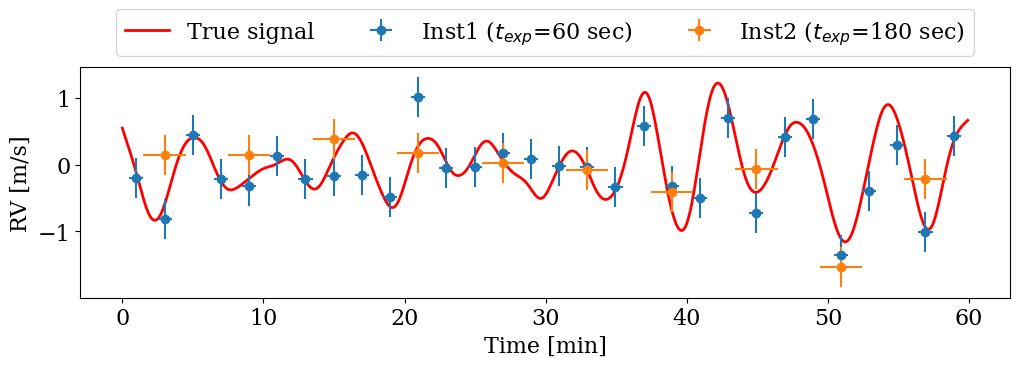

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
# ax.errorbar(tobs.value, y_inst,  yerr=yerr, fmt='o', color='grey')
# ax.errorbar(tobs.value, y_train, xerr=texp/60/2, yerr=yerr, fmt='o', color='k', label=r'$t_{exp}$=' + f'{texp} sec')
for instid in range(Ninst):
    inst = (instids==instid)
    ax.errorbar(tobs.value[inst], y_train[inst], xerr=texp_train[inst]/60/2, yerr=yerr,
                 fmt='o', label=f'Inst{instid+1} ($t_{{exp}}$={texp_train[inst][0]} sec)')

ax.legend(ncol=3, bbox_to_anchor=[0.5,1], loc='lower center')
ax.set(ylabel='RV [m/s]', xlabel=f'Time [{t.unit}]');

In [ ]:
tmid = t_train # exposure midpoints

## Construct interleaved time array for integrated Kalman/RTS
ts = tmid - texp_train/2  # Exposure start times
te = tmid + texp_train/2  # Exposure end times
obsid = jnp.arange(len(tmid)).repeat(2)  # which observation does each time belong to

# Interleave start and end times into one array (fastest)
# https://stackoverflow.com/questions/5347065/interleaving-two-numpy-arrays-efficiently
t_states = np.empty((ts.size + te.size,), dtype=tmid.dtype)
t_states[0::2] = ts  # evens are start times
t_states[1::2] = te  # odds are end times
# Have to re-sort because exposures can overlap
sortidx  = jnp.argsort(t_states)
t_states = t_states[sortidx]
obsid    = obsid[sortidx] 
stateids = jnp.tile(jnp.array([0,1]), len(tmid))[sortidx] # 0 for t_s, 1 for t_e

In [ ]:
print('k   t[s]    obs  inst  state')
print('----------------------------')
for k in range(len(t_states)):
    print(f'{k:<2d}  {t_states[k]:<7.1f}  {obsid[k]:<2}   {instids[obsid[k]]}   {stateids[k]}')
    if k>8:
        break

k   t[s]    obs  inst  state
----------------------------
0   30.0     0    0   0
1   90.0     0    0   1
2   90.0     2    1   0
3   149.8    1    0   0
4   209.8    1    0   1
5   269.7    3    0   0
6   270.0    2    1   1
7   329.7    3    0   1
8   389.5    4    0   0
9   449.4    6    1   0


## Run integrated solver

In [ ]:
# Kalman filters
kalman_results = kalman_filter_integrated(t_states, y_train, texp_train, 
                                          obsid, instids, stateids, 
                                          R, H)
                                          
m_filtered_int, P_filtered_int, m_predicted_int, P_predicted_int = kalman_results

# RTS smoother
m_smooth_int, P_smooth_int = rts_smoother_integrated(t_states, obsid, instids, stateids,
                                                     m_filtered_int,  P_filtered_int, 
                                                     m_predicted_int, P_predicted_int)

In [ ]:
k = 0
print(f'(k={k}) |', ['Start of obs', 'End of obs'][stateids[k]], obsid[k], f'(Inst: {instids[obsid[k]]})')
print('State:    ', "[x x'" + ''.join([f" z{i} z{i}" for i in range(Ninst)]) + ']')
print('----------------------------')
print('Predicted:', m_predicted_int[k])
print('Filtered: ', m_filtered_int[k])
print('Smoothed: ', m_smooth_int[k])

(k=0) | Start of obs 0 (Inst: 0)
State:     [x x' z0 z0 z1 z1]
----------------------------
Predicted: [0. 0. 0. 0. 0. 0.]
Filtered:  [0. 0. 0. 0. 0. 0.]
Smoothed:  [ 1.59685793e-01 -6.47741666e-03  0.00000000e+00  0.00000000e+00
 -1.65120116e-16  4.40591571e-17]


In [ ]:
print('Predicted:\n', P_predicted_int[k])
print('Filtered:\n', P_filtered_int[k])
print('Smoothed:\n', P_smooth_int[k])

Predicted:
 [[3.51132600e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.33518171e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Filtered:
 [[3.51132600e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.33518171e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000000

In [ ]:
# Project predictive mean/var to observation space
H_n = lambda n: H / texp_train[n]  ## observation model at exposure n

## Augmented observation model
# C_k = lambda k: jnp.hstack([jnp.zeros_like(H_n(obsid[k])), H_n(obsid[k])]) # for integral state
# C_k = lambda k: jnp.hstack([H, jnp.zeros_like(H)]) # for instantaneous state    
def C_k(k):
    n = obsid[k]
    # H_k = H_n(n)
    Ck = jax.lax.dynamic_update_slice(jnp.zeros(d*(1+Ninst)), jnp.array([1.,0.])/texp_train[n], (d*(1+instids[n]),))
    return jnp.array([Ck])
C_k = jax.vmap(C_k)(jnp.arange(len(t_states)))

In [ ]:
# y_ss = jnp.array([H_k[k] @ m_smooth_int[k].T for k in range(N)]).squeeze()
# yvar_ss = jnp.array([H_k[k] @ P_smooth_int[k] @ H_k[k].T for k in range(N)]).squeeze()

## Extract observed integral state for computing residuals
K = len(m_smooth_int)
y_ss = jnp.array([C_k[k] @ m_smooth_int[k].T for k in range(K)]).squeeze()
yvar_ss = jnp.array([C_k[k] @ P_smooth_int[k] @ C_k[k].T for k in range(K)]).squeeze()

# extract the end-states and put into original order (i.e. that matches t_train)
end_states = stateids==1
y_ss    = y_ss[end_states][obsid[end_states]]
yvar_ss = yvar_ss[end_states][obsid[end_states]]

In [ ]:
# y_ss = (Hbar @ m_smooth_int.T).squeeze()
# yvar_ss = (Hbar @ P_smooth_int @ Hbar.T).squeeze()
yerr_ss = jnp.sqrt(yvar_ss)

In [ ]:
# Predict at test times using both the instantaneous start/end smoothed states
mu_ss, var_ss = predict_at_times_integrated(m_smooth_int,    P_smooth_int, 
                                            m_filtered_int,  P_filtered_int,
                                            m_predicted_int, P_predicted_int,
                                            t_states, t_test, 
                                            Htest=None)
std_ss = jnp.sqrt(var_ss)

In [ ]:
np.all(np.isfinite(m_predicted_int)),\
np.all(np.isfinite(m_filtered_int)),\
np.all(np.isfinite(m_smooth_int))

(np.True_, np.True_, np.True_)

In [ ]:
np.all(np.isfinite(P_predicted_int)),
np.all(np.isfinite(P_filtered_int)),
np.all(np.isfinite(P_smooth_int))

np.True_

In [ ]:
np.all(np.isfinite(mu_ss)), np.all(np.isfinite(std_ss))

(np.True_, np.True_)

### GP version for comparison

In [ ]:
diag = yerr**2 

# Exposure start, mid, endtimes
texps = u.Quantity(texp_train, 's')
tstart, tend = (tobs - texps/2).to('s').value, (tobs + texps/2).to('s').value

### integrated prediction at data points 
zeros = jnp.zeros_like(t_train) # for instid
texp_pred = u.Quantity(texp_train, 's') # use exposure time
tup = (tobs, jnp.zeros_like(tobs), texp_pred)
### instantaneous prediction on test grid
ts = u.Quantity(t_test, 's').to('min')
zeros = jnp.zeros_like(t_test) # for instid
zeroexp = u.Quantity(jnp.zeros_like(t_test), 's') # for instantaneous curve
tups = (ts, zeros, zeroexp)
### Full GP predictions
sho_intkern = gpkernels.IntegratedOscillationKernel()
gp = tinygp.GaussianProcess(sho_intkern, tup, diag=diag)
y_gp, yvar_gp = gp.predict(y_train, tup,  return_var=True)
mu_gp, var_gp = gp.predict(y_train, tups, return_var=True)
yerr_gp = jnp.sqrt(yvar_gp)
std_gp  = jnp.sqrt(var_gp)

Defaulting to solar values.


In [ ]:
in_exposure = jnp.zeros_like(t_test, dtype=bool)
for t1, t2 in zip(t_states[0::2], t_states[1::2]):
    in_exposure = in_exposure | ((t_test >= t1) & (t_test <= t2))

In [ ]:
# tinygp does this by defining a `Block` object as a type of quasisep solver 
#   that overwrites the various matrix operations (__mul__, to_dense, transpose, etc.) 
#   those are then what the quasisep solver uses when doing the matrix algebra.
# Then defines a Sum(Quasisep) object of the same form as the actual Quasisep objects
#   but where each component matrix is a Block of the two components. 
#   Then, the Quasisep object has __add__ overwritten to use this Sum(self, other)